In [1]:
import sys
sys.path.append("../SpikeCounter")
import numpy as np
import skimage.io as skio
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imsave
import matplotlib.colors as colors
import matplotlib.patches as patches
import os
from scipy import interpolate, optimize, ndimage, stats, signal
from skimage import filters, transform, morphology, exposure, measure
from spikecounter.analysis import traces, images
from spikecounter.ui import visualize
from spikecounter.ui import stackViewer
from spikecounter import utils
import colorcet as cc
from cycler import cycler
from scipy.io import loadmat
import mat73
from sklearn.utils.extmath import randomized_svd
import pandas as pd
import importlib
from statannotations.Annotator import Annotator

import seaborn as sns
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")

In [2]:
def reload_libraries():
    importlib.reload(images)
    importlib.reload(traces)
    importlib.reload(utils)
    importlib.reload(visualize)

In [3]:
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures/"
rootdir = "/n/holyscratch01/cohen_lab/bjia/20220825_prebeat_waveprop/aesthetic_video/"

### Load metadata and video

In [9]:
reload_libraries()

In [4]:
filename = "092322DRBJ009_E3_OD0_target3_fast"
nkx_path = "090837DRBJ009_E3_OD0_target3.tiff"

In [5]:
img, expt_data = images.load_image(rootdir, filename, subfolder="corrected")
traces_dict, t = utils.traces_to_dict(expt_data)
dt = np.mean(np.diff(t))
t = t[:img.shape[0]]

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220825_prebeat_waveprop/aesthetic_video/corrected/092322DRBJ009_E3_OD0_target3_fast/Sq_camera.bin'


### Get biological landmark

In [6]:

nkx = skio.imread(os.path.join(rootdir, "Snaps", nkx_path))
factor = 4
nkx_downsample = transform.downscale_local_mean(nkx, (factor,factor))


In [7]:
img.shape

(2191, 216, 216)

In [8]:
offset = [(nkx_downsample.shape[0]-img.shape[1])//2, (nkx_downsample.shape[1]-img.shape[2])//2]
if offset[0] > 0:
    nkx_downsample = nkx_downsample[offset[0]:-offset[0],offset[1]:-offset[1]]

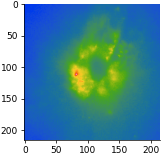

In [9]:
plt.imshow(nkx_downsample)

In [10]:
mean_intensity = img.mean(axis=0)

/tmp/ipykernel_40740/3084213661.py:2: FutureWarning: `footprint` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0. Please use `footprint` instead.
  img_mask = morphology.binary_closing(img_mask, footprint = np.ones((10,10)))


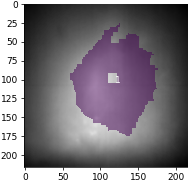

In [11]:
img_mask = nkx_downsample > np.percentile(nkx_downsample, 80)
img_mask = morphology.binary_closing(img_mask, footprint = np.ones((10,10)))

fig1, ax1 = plt.subplots(figsize=(3,3))
q = visualize.display_roi_overlay(mean_intensity, img_mask.astype(int), ax=ax1)

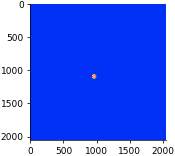

In [12]:
plt.imshow(expt_data["dmd_lightcrafter"]['target_image_space'])

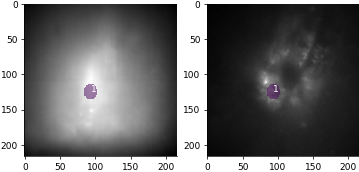

In [13]:
factor = 4
fig1, axes = plt.subplots(1,2, figsize=(6,3))
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
# plt.imshow(target_img_space)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
target_img_space = target_img_space.astype(bool)
q = visualize.display_roi_overlay(mean_intensity, target_img_space.astype(int), ax=axes[0])
q2 = visualize.display_roi_overlay(nkx_downsample, target_img_space.astype(int), ax=axes[1])

In [81]:
reload_libraries()

In [76]:
k1 = 6
k2 = 20
img_filtered = ndimage.gaussian_filter(img, (2,k1,k1)) - ndimage.gaussian_filter(img, (2, k2,k2)) 

In [88]:
dFF = images.get_image_dFF(img, baseline_percentile=50, t_range=(0,200))


In [89]:
tr1 = images.extract_mask_trace(dFF, target_img_space)

In [90]:
mask2 = np.zeros_like(target_img_space)
mask2[150:160, 40:50] = 1
tr2 = images.extract_mask_trace(dFF, mask2)

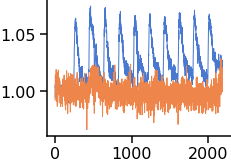

In [91]:
plt.plot(tr1)
plt.plot(tr2)

In [92]:
skio.imsave(os.path.join(rootdir, "dFF_test.tif"), exposure.rescale_intensity(dFF, out_range=np.uint8))

In [14]:
rising_edges = np.argwhere(np.diff(traces_dict["enable488"]) > 0)

In [28]:
sta, _ = images.spike_triggered_average_video(dFF, rising_edges, int(1/dt), int(3/dt))

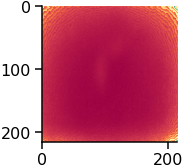

In [31]:
plt.imshow(dFF.mean(axis=0))

In [ ]:
g1 = ndimage.gaussian_filter(sta, (0,k1,k1))
g2 = ndimage.gaussian_filter(sta, (0,k2,k2))
dog = g1 - g2

In [37]:
skio.imsave(os.path.join(rootdir, "sta_filtered.tif"), exposure.rescale_intensity(dog, out_range=np.uint8))

In [35]:
skio.imsave(os.path.join(rootdir, "sta_filtered2.tif"), exposure.rescale_intensity(dog, out_range=np.uint8))

In [29]:
skio.imsave(os.path.join(rootdir, "sta.tif"), exposure.rescale_intensity(sta, out_range=np.uint8))

In [93]:
k1 = 6
k2 = 20

In [94]:
dog_fill = ndimage.gaussian_filter(dFF, (2,k1,k1)) - ndimage.gaussian_filter(dFF, (2, k2,k2)) 

In [95]:
dog_full2 = np.copy(dog_fill)

In [99]:
skio.imsave(os.path.join(rootdir, "dFF_smoothed.tif"), exposure.rescale_intensity(dog_full2,\
                                    in_range=tuple(np.nanpercentile(dog_full2, [1,99])), out_range=np.uint8))

In [15]:
img.shape

(2191, 216, 216)

ERROR! Session/line number was not unique in database. History logging moved to new session 2093


## Make nice combined images

In [21]:
cochr_video = np.tile(exposure.rescale_intensity(nkx_downsample, out_range=np.uint8), (img.shape[0], 1, 1))

In [23]:
skio.imsave(os.path.join(rootdir, "cochr_video.tif"), cochr_video)

In [18]:
stim_targets = np.zeros_like(img, dtype=np.uint8)

In [101]:
for i in range(4):
    stim_targets[rising_edges+i] = target_img_space.astype(int)*255


In [102]:
skio.imsave(os.path.join(rootdir, "stim_target_video.tif"), stim_targets)

/tmp/ipykernel_40740/2858029718.py:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20220825_prebeat_waveprop/aesthetic_video/stim_target_video.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "stim_target_video.tif"), stim_targets)
